In [2]:
import numpy as np
import numpy.random as npr
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

48928
34.0
0
447


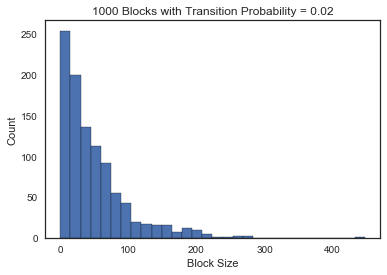

In [76]:
tprob = 0.02 # set transition probability
duration_list = []
for ind in range(0,1000): # generate array consisting of each trial length
    xrand = np.random.random_sample(1000) # generate array of random numbers between 0 and 1
    duration_list.append(np.min(np.where(xrand<tprob))) # save value for number draws required to fall below transition probability the first time
plt.hist(duration_list, bins=30, edgecolor='black')
num_trials = sum(duration_list)
plt.xlabel('Block Size')
plt.ylabel('Count')
plt.title("1000 Blocks with Transition Probability = %s" %(tprob))
print(num_trials)
print(np.median(duration_list))
print(np.min(duration_list))
print(np.max(duration_list))


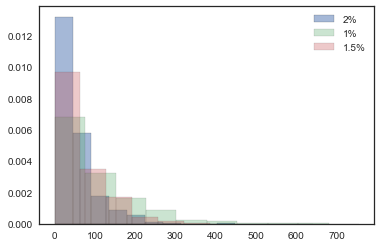

In [84]:
plt.hist(duration_list_02, bins=30 edgecolor='black', alpha=0.5, normed=True)
plt.hist(duration_list_01, bins=30, edgecolor='black', alpha=0.3, normed=True)
plt.hist(duration_list_015, bins=30, edgecolor='black', alpha=0.3, normed=True)
plt.legend(['2%', '1%', '1.5%'])

(array([ 0.59 ,  0.259,  0.079,  0.039,  0.026,  0.004,  0.002,  0.   ,
         0.   ,  0.001]),
 array([   0. ,   44.7,   89.4,  134.1,  178.8,  223.5,  268.2,  312.9,
         357.6,  402.3,  447. ]),
 <a list of 10 Patch objects>)

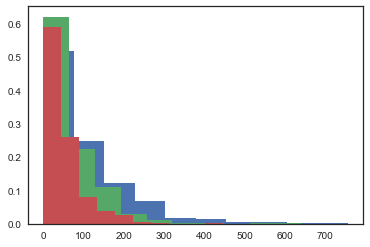

In [139]:
weights_01 = np.ones_like(duration_list_01)/float(len(duration_list_01))
plt.hist(duration_list_01, weights=weights_01)
weights_015 = np.ones_like(duration_list_015)/float(len(duration_list_015))
plt.hist(duration_list_015, weights=weights_015)
weights_02 = np.ones_like(duration_list_02)/float(len(duration_list_02))
plt.hist(duration_list_02, weights=weights_02)

In [187]:
bins_02_percent = [x/1000 for x in  n_02]
bins_01_percent = [x/1000 for x in n_01]
bins_015_percent = [x/1000 for x in n_015]


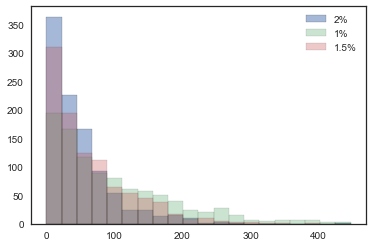

In [184]:
n_02, bins, patches = plt.hist(duration_list_02, bins=20, alpha=0.5, edgecolor='black')
n_01, bins, patches = plt.hist(duration_list_01, bins=bins, alpha=0.3, edgecolor='black')
n_015, bins, patches = plt.hist(duration_list_015, bins=bins, alpha=0.3, edgecolor='black')
plt.legend(['2%', '1%', '1.5%'])

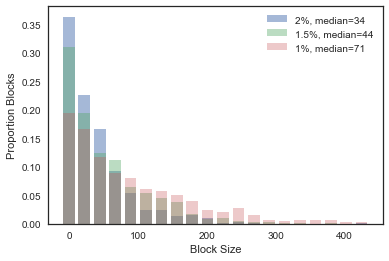

In [198]:
plt.bar(bins[0:20], bins_02_percent, width=17,alpha=0.5)
plt.bar(bins[0:20], bins_015_percent, width=17, alpha=0.4)
plt.bar(bins[0:20], bins_01_percent, width=17, alpha=0.3)
plt.legend(['2%, median=34', '1.5%, median=44', '1%, median=71'])
plt.xlabel('Block Size')
plt.ylabel('Proportion Blocks')


In [199]:
bins

array([   0.  ,   22.35,   44.7 ,   67.05,   89.4 ,  111.75,  134.1 ,
        156.45,  178.8 ,  201.15,  223.5 ,  245.85,  268.2 ,  290.55,
        312.9 ,  335.25,  357.6 ,  379.95,  402.3 ,  424.65,  447.  ])

In [134]:
n/1000

array([ 0.119,  0.121,  0.086,  0.089,  0.079,  0.057,  0.054,  0.05 ,
        0.047,  0.051,  0.035,  0.029,  0.027,  0.016,  0.022,  0.013,
        0.01 ,  0.006,  0.01 ,  0.006,  0.006,  0.01 ,  0.008,  0.006,
        0.004,  0.004,  0.002,  0.007,  0.005,  0.004])

In [10]:
#parameters
n_plays = 100

plays_executed = 0
durations_included=[]
for ind in duration_list:        
    
    if plays_executed > n_plays:
        break
    durations_included.append(ind)
    duration = ind
    #true latent state sequence
    state = (np.arange(n_plays)) // duration % 2 #this just returns [0,0,....,1,1,...] etc 
    #for each state so we can keep track. 

    #transition matrix
    '''
    set transition matrix T such that T[i,j] is the probability of transitioning
    from state i to state j. 
    If the true number of trials before switching is 'duration', then set the
    probability of switching to be 1 / duration, and the probability of 
    staying to 1 - 1 / duration
    '''
    s = 1 - 1./duration
    T = np.array([[s, 1.0-s],
                [1.0-s,s]])

    #reward probabilties
    p = 0.8 # prob of reward if choose the correct side
    q = 0.2 # prob of reward if choose the incorrect side

    #observation array
    '''
    set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

    eg. when action = L, observation matrix should be:
    O[:,:,1]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
                  P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
                = [1-p, 1-q
                  p,   q]
    '''
    O = np.zeros((2,2,2))
    # let a 'right' choice be represented by '0'
    O[:,:,0] = np.array([[1.0-p, 1.0-q],
                        [p,q]])
    O[:,:,1] = np.array([[1.0-q, 1.0-p],
                        [q,p]])

    #TEST: All conditional probability distributions must sum to one
    assert np.allclose(O.sum(0),1), "All conditional probability distributions must sum to one!"

    #Initialize an array for actions (a[i] = 0 --> right, a[i] = 1 --> left)
    actions = np.zeros(n_plays)

    #Initialize an array for rewards (outcomes) (1 = reward, 0 = no reward)
    rewards = np.zeros(n_plays)

    #Keep track of beliefs over which side will be rewarded
    #First column is left, second is right
    beliefs = np.nan*np.ones((n_plays+1,2)) # +1 since the belief is always about the next trial

    #initialize with both sides equally likely
    beliefs[0] = [0.5,0.5]

    trials = np.zeros((n_plays,4))

    #run the algorithm
    for play in range(n_plays):
        assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"

        #choose an action
        '''
        different strategies could be employed here.
        eg 'greedy' <-- where action[play] = np.argmax(beliefs[play]). However
        this is actually suboptimal because it doesn't do any exploration. 

        in Thompson sampling, instead want to sample from your belief probabilities:
        ie actions[play] ~ beliefs[play]
        '''

        '''
        THOMPSON SAMPLING
        '''
        actions[play] = npr.choice(2,p=beliefs[play])
        '''
        GREEDY
        ''' 
        #actions[play] = np.where(beliefs[play] == beliefs[play].max())[0][0]

        '''
        EPSILON-GREEDY
        '''
        '''
        if np.random.uniform(size=1) > epsilon:
            actions[play] = np.where(beliefs[play] == beliefs[play].max())[0][0]
        else:
            actions[play] = np.where(beliefs[play] == beliefs[play].min())[0][0]
        '''

        #recieve reward based on the action
        p_reward = O[:,state[play],int(actions[play])]
        rewards[play] = npr.choice(2,p=p_reward) #bc of the way we set up the outcomes matrix, the first prob corresponds
            #to not getting a reward, so we get a 0 for no reward and a 1 for a reward :)


        '''
        update trial matrix
        1. time
        2. port (1=right,2=left)
        3. right port reward porb
        4. left port reward prob
        5. reward given 1/0

        obviously we won't encode a time.
        '''
        # action (port)
        trials[play,0] = actions[play]+5 #the 2s need to become zeros after


        if state[play] == 1: #we are in a 'left' state
            trials[play,[1,2]] = [q,p]
        else: # we are in a 'right' state
            trials[play,[1,2]] = [p,q]

        # outcome (reward given y/n)
        trials[play,3] = rewards[play]


        #update beliefs

        #step 1: multiply by p(r_t | z_t = k, a_t)
        belief_temp = O[int(rewards[play]),:,int(actions[play])] * beliefs[play]

        #step 2: sum over z_t, weighting by transition matrix
        beliefs[play+1] = T.dot(belief_temp)

        #step 3: normalize
        beliefs[play+1] /= beliefs[play+1].sum()
        
        plays_executed = plays_executed + 1

    #switch ports
    trials[trials[:,0] == 5,0] = 1
    trials[trials[:,0] == 6,0] = 2



In [11]:
cum_duration_list = np.zeros_like(durations_included)
for ind in range(0,len(durations_included)):
    cum_duration_list[ind] = np.sum(durations_included[0:ind+1])

In [12]:
duration_list

[25, 31, 17, 15, 50, 4, 32, 34, 10, 29, 15, 11, 12, 9, 54, 5, 9, 39, 1, 2]

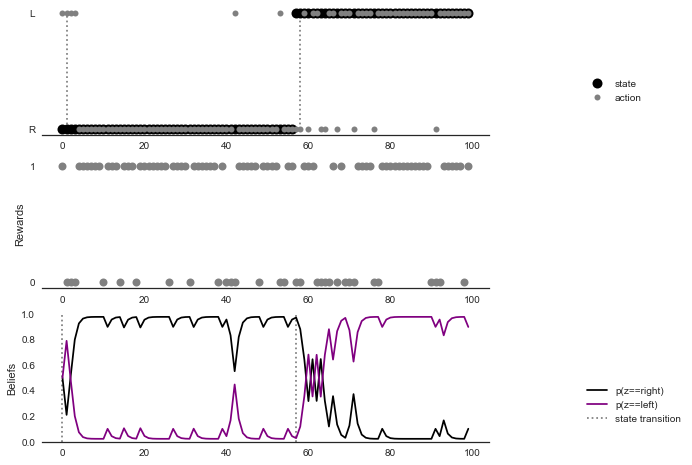

In [8]:
# Plot
sns.set_style('white')
plt.figure(figsize=(8,8))

plt.subplot(311)
plt.plot(state, 'ko', markersize=10, markeredgecolor="none", label="state",alpha=1.0)
plt.plot(actions, 'o',color='grey', markersize=6, markeredgecolor="none", label="action")
#plt.plot(actions[np.where(rewards==1)], 'go', markersize=6, markeredgecolor="none", label="action")
#plt.plot(actions[np.where(rewards==0)], 'bo', markersize=6, markeredgecolor="none", label="action")

for x in cum_duration_list:
    label = 'state transition' if x==0 else None
    plt.vlines(x=x, ymin=0, ymax=1, color='grey', linestyles=':', label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1.2,0.5,0,0))
plt.yticks([0,1], ["R", "L"])
plt.ylim(-0.05,1.05)

plt.subplot(312)
plt.plot(rewards, 'o',color='grey', markersize=8)
plt.ylabel("Rewards")
plt.yticks([0,1])
plt.ylim(-0.05,1.05)

plt.subplot(313)
plt.plot(np.arange(n_plays), beliefs[:-1, 0], color='black', label='p(z==right)')
plt.plot(np.arange(n_plays), beliefs[:-1, 1], color='purple', label='p(z==left)')
sns.despine(left=True)
for x in range(0,n_plays,duration):
    label = 'state transition' if x==0 else None
    plt.vlines(x=x, ymin=0, ymax=1, color='grey', linestyles=':', label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1.2,0.5,0,0))
plt.ylim(0,1)
plt.ylabel("Beliefs")

In [14]:
actions[list(map(bool,rewards))]

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [15]:
actions[np.where(rewards==1)]

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
np.savetxt('/Users/shayneufeld/GitHub/mouse_bandit/data/trials_hmm_full_7030_greedy.csv',trials,delimiter=',')